# My Lesson 2 - Linear model with CNN features

In [1]:
%matplotlib inline
import utils; reload(utils)
from utils import *

Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5103)
/home/ubuntu/anaconda2/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)
Using Theano backend.


In [2]:
from __future__ import division,print_function
import os, json
from glob import glob
import numpy as np
import scipy
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix
np.set_printoptions(precision=4, linewidth=100)
from matplotlib import pyplot as plt
import utils; reload(utils)
from utils import plots, get_batches, plot_confusion_matrix, get_data

In [3]:

from numpy.random import random, permutation
from scipy import misc, ndimage
from scipy.ndimage.interpolation import zoom

import keras
from keras import backend as K
from keras.utils.data_utils import get_file
from keras.models import Sequential
from keras.layers import Input
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import SGD, RMSprop
from keras.preprocessing import image

## Linear model in Keras

In [5]:
x = random((30,2))
y = np.dot(x, [4, 5]) +1

In [6]:
x[:4]

array([[ 0.4697,  0.3919],
       [ 0.9616,  0.4443],
       [ 0.9533,  0.8984],
       [ 0.2386,  0.705 ]])

In [7]:
y[:4]

array([ 4.8383,  7.0678,  9.3049,  5.4791])

In [14]:
lm = Sequential()
# lm.add(Dense(1, input_shape=(2,)))
lm.add(Dense(1, input_dim=2))

lm.compile(optimizer=SGD(lr=0.1), loss='mse')

In [15]:
lm.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
dense_3 (Dense)                  (None, 1)             3           dense_input_3[0][0]              
Total params: 3
____________________________________________________________________________________________________


In [20]:
lm.fit(x, y, nb_epoch=5, batch_size=1)

Epoch 1/5
30/30 [==============================] - 0s - loss: 1.0111e-04     
Epoch 2/5
30/30 [==============================] - 0s - loss: 7.8359e-05     
Epoch 3/5
30/30 [==============================] - 0s - loss: 4.9370e-05     
Epoch 4/5
30/30 [==============================] - 0s - loss: 3.3545e-05     
Epoch 5/5
30/30 [==============================] - 0s - loss: 2.0013e-05     


In [22]:
layer = lm.layers[0]

In [24]:
layer.get_weights()

[array([[ 3.9908],
        [ 4.988 ]], dtype=float32), array([ 1.0131], dtype=float32)]

## Training linear model on predictions

In [7]:
path = "/home/ubuntu/data/dogscats/"
model_path = path + 'models/'
if not os.path.exists(model_path): os.mkdir(model_path)

In [8]:
batch_size = 128

In [9]:
from vgg16 import Vgg16

vgg = Vgg16()
model = vgg.model

In [22]:
val_batches = get_batches(path+'valid', shuffle=False, batch_size=1)
batches = get_batches(path+'train', shuffle=False, batch_size=1)

Found 2000 images belonging to 2 classes.
Found 23000 images belonging to 2 classes.


In [31]:

import bcolz
def save_array(fname, arr): c=bcolz.carray(arr, rootdir=fname, mode='w'); c.flush()
def load_array(fname): return bcolz.open(fname)[:]


Join arrays from all batches

In [34]:
val_data = get_data(path+'valid')
train_data = get_data(path+'train')

Found 2000 images belonging to 2 classes.
Found 23000 images belonging to 2 classes.


In [35]:
train_data.shape

(23000, 3, 224, 224)

In [37]:
save_array(model_path+ 'train_data.bc', train_data)
save_array(model_path + 'valid_data.bc', val_data)

In [10]:
train_data = load_array(model_path+ 'train_data.bc')
val_data = load_array(model_path + 'valid_data.bc')

In [23]:
val_classes = val_batches.classes
train_classes = batches.classes
val_labels = onehot(val_classes)
train_labels = onehot(train_classes)

In [14]:
train_labels.shape

(23000, 2)

In [15]:
train_classes[:4]

array([0, 0, 0, 0], dtype=int32)

In [16]:
train_classes[:-4]

array([0, 0, 0, ..., 1, 1, 1], dtype=int32)

In [17]:
train_labels[:4]

array([[ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.]])

In [15]:
trn_features = model.predict(train_data, batch_size=128)
val_features = model.predict(val_data, batch_size=128)

KeyboardInterrupt: 

In [26]:
trn_features.shape

(23000, 1000)

In [28]:
save_array(model_path+'train_lastlayer_features.bc', trn_features)
save_array(model_path+'valid_lastlayer_features.bc', val_features)

In [17]:
train_features = load_array(model_path+'train_lastlayer_features.bc')
val_features = load_array(model_path+'valid_lastlayer_features.bc')

In [18]:
linear_model = Sequential()
linear_model.add(Dense(2, input_dim=1000, activation='softmax'))
linear_model.compile(optimizer=RMSprop(lr=0.1), loss='categorical_crossentropy', metrics=['accuracy'])

In [19]:
batch_size = 64

In [25]:
linear_model.fit(train_features, train_labels, nb_epoch=4, batch_size=batch_size, validation_data=(val_features, val_labels))

Train on 23000 samples, validate on 2000 samples
Epoch 1/4
23000/23000 [==============================] - 0s - loss: 0.0806 - acc: 0.9779 - val_loss: 0.1025 - val_acc: 0.9745
Epoch 2/4
23000/23000 [==============================] - 0s - loss: 0.0814 - acc: 0.9784 - val_loss: 0.1060 - val_acc: 0.9760
Epoch 3/4
23000/23000 [==============================] - 0s - loss: 0.0818 - acc: 0.9793 - val_loss: 0.1073 - val_acc: 0.9760
Epoch 4/4
23000/23000 [==============================] - 0s - loss: 0.0820 - acc: 0.9793 - val_loss: 0.1091 - val_acc: 0.9755


In [41]:
linear_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
dense_4 (Dense)                  (None, 2)             2002        dense_input_1[0][0]              
Total params: 2002
____________________________________________________________________________________________________


## Metrics

In [26]:
batch_size = 128

In [45]:
# We want both the classes...
preds = linear_model.predict_classes(val_features, batch_size=batch_size)
# ...and the probabilities of being a cat
probs = linear_model.predict_proba(val_features, batch_size=batch_size)[:,0]

1664/2000 [=======================>......] - ETA: 0s

In [49]:
cm = confusion_matrix(val_classes, preds)

[[974  26]
 [ 26 974]]


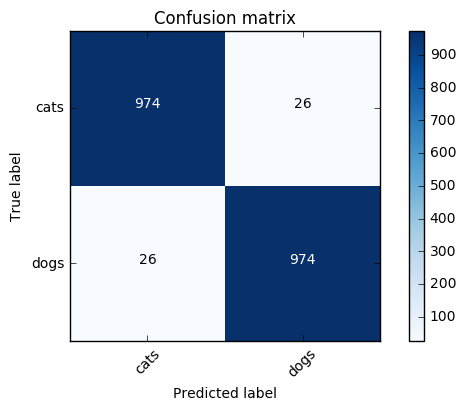

In [50]:
plot_confusion_matrix(cm, val_batches.class_indices)

In [27]:
vgg.model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_1 (Lambda)                (None, 3, 224, 224)   0           lambda_input_1[0][0]             
____________________________________________________________________________________________________
zeropadding2d_1 (ZeroPadding2D)  (None, 3, 226, 226)   0           lambda_1[0][0]                   
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 64, 224, 224)  1792        zeropadding2d_1[0][0]            
____________________________________________________________________________________________________
zeropadding2d_2 (ZeroPadding2D)  (None, 64, 226, 226)  0           convolution2d_1[0][0]            
___________________________________________________________________________________________

In [28]:
model.pop()

In [29]:
for layer in model.layers: layer.trainable=False

In [30]:
model.add(Dense(2, activation='softmax'))

In [31]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_1 (Lambda)                (None, 3, 224, 224)   0           lambda_input_1[0][0]             
____________________________________________________________________________________________________
zeropadding2d_1 (ZeroPadding2D)  (None, 3, 226, 226)   0           lambda_1[0][0]                   
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 64, 224, 224)  0           zeropadding2d_1[0][0]            
____________________________________________________________________________________________________
zeropadding2d_2 (ZeroPadding2D)  (None, 64, 226, 226)  0           convolution2d_1[0][0]            
___________________________________________________________________________________________

shuffle the training batches, to add more randomness when using multiple epochs

In [39]:
batch_size = 64*2

In [40]:
gen=image.ImageDataGenerator()
batches = gen.flow(train_data, train_labels, batch_size=batch_size, shuffle=True)
val_batches = gen.flow(val_data, val_labels, batch_size=batch_size, shuffle=False)

In [41]:
def fit_model(model, batches, val_batches, nb_epoch=1):
    model.fit_generator(batches, samples_per_epoch=batches.N, nb_epoch=nb_epoch, 
                        validation_data=val_batches, nb_val_samples=val_batches.N)

In [42]:
opt = RMSprop(lr=0.1)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])


In [43]:
fit_model(model, batches, val_batches, nb_epoch=2)

Epoch 1/2
23000/23000 [==============================] - 631s - loss: 0.6656 - acc: 0.9577 - val_loss: 0.5189 - val_acc: 0.9655
Epoch 2/2
23000/23000 [==============================] - 620s - loss: 0.5364 - acc: 0.9658 - val_loss: 0.4079 - val_acc: 0.9745


### Retrain all Dense layers

NB: Don't skip the step of fine-tuning just the final layer first, since otherwise you'll have one layer with random weights, which will cause the other layers to quickly move a long way from their optimized imagenet weights.

In [44]:
layers = model.layers
# Get the index of the first dense layer...
first_dense_idx = [index for index,layer in enumerate(layers) if type(layer) is Dense][0]
# ...and set this and all subsequent layers to trainable
for layer in layers[first_dense_idx:]: layer.trainable=True

Since we haven't changed our architecture, there's no need to re-compile the model - instead, we just set the learning rate. Since we're training more layers, and since we've already optimized the last layer, we should use a lower learning rate than previously.

In [47]:
K.set_value(opt.lr,0.01)
fit_model(model, batches, val_batches, 3)

Epoch 1/3
23000/23000 [==============================] - 623s - loss: 0.4772 - acc: 0.9698 - val_loss: 0.3755 - val_acc: 0.9765
Epoch 2/3
23000/23000 [==============================] - 622s - loss: 0.4305 - acc: 0.9729 - val_loss: 0.3545 - val_acc: 0.9770
Epoch 3/3
23000/23000 [==============================] - 622s - loss: 0.4119 - acc: 0.9738 - val_loss: 0.3320 - val_acc: 0.9785


In [48]:
model.save_weights(model_path+'finetune_alldenselayers.h5')

### Retrain some Conv2D layers

In [49]:
for layer in layers[12:]: layer.trainable=True
K.set_value(opt.lr, 0.001)

In [50]:
fit_model(model, batches, val_batches, 4)

Epoch 1/4
23000/23000 [==============================] - 623s - loss: 0.3872 - acc: 0.9753 - val_loss: 0.3349 - val_acc: 0.9785
Epoch 2/4
23000/23000 [==============================] - 622s - loss: 0.3945 - acc: 0.9748 - val_loss: 0.3308 - val_acc: 0.9790
Epoch 3/4
23000/23000 [==============================] - 622s - loss: 0.3729 - acc: 0.9763 - val_loss: 0.3324 - val_acc: 0.9790
Epoch 4/4
23000/23000 [==============================] - 623s - loss: 0.3731 - acc: 0.9764 - val_loss: 0.3229 - val_acc: 0.9795


In [51]:
model.save_weights(model_path+'finetune_conv_and_dense.h5')